# Problem Statement

In this project, we aim to predict the **exact quality score of red wine**, ranging from **3 to 8**, based on physicochemical test data such as acidity, sugar levels, pH, and alcohol content. 

Unlike traditional regression approaches, we reframe this task as a **multi-class classification problem** where each class corresponds to a specific quality score. This framing allows for better interpretability and supports real-world applications where wines are often graded into discrete quality categories.

Our goal is to build a robust predictive model that can assist wineries in estimating the expected quality of a wine early in the production pipeline.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [2]:
# Load the dataset
df = pd.read_csv("winequality-red.csv")

# Problem Specific Exploratory Data Analysis

We begin with a visual and statistical exploration of the dataset to understand how each feature correlates with wine quality. This helps guide both feature selection and model design.

We analyze:
- Distribution of quality scores (to reveal class imbalance)


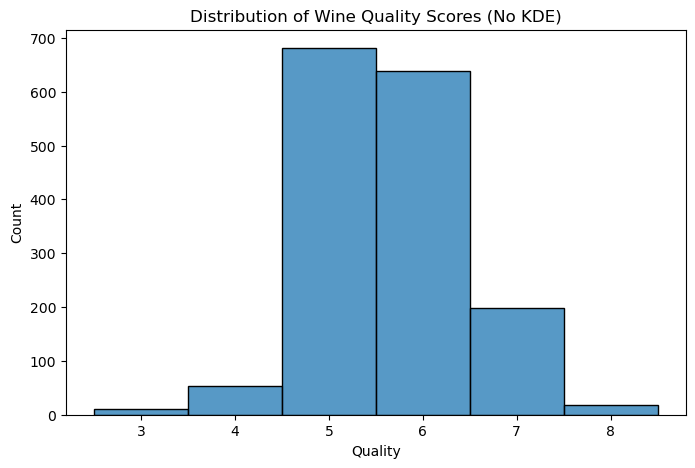

In [18]:
# Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['quality'], bins=range(3, 10), discrete=True)
plt.title("Distribution of Wine Quality Scores (No KDE)")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()


# Baseline Model (No Upsampling)

We first train an XGBoost classifier directly on the imbalanced dataset to establish a performance baseline. This highlights the challenges posed by real-world data imbalance and provides a reference point for improvement.



In [19]:
# Encode target
le = LabelEncoder()
df['quality_encoded'] = le.fit_transform(df['quality'])

# Split data
X = df.drop(['quality', 'quality_encoded'], axis=1)
y = df['quality_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train baseline model
baseline_model = XGBClassifier(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)

# Evaluate baseline
y_pred_base = baseline_model.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_base)))

Baseline Accuracy: 0.6625
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.50      0.09      0.15        11
           5       0.72      0.72      0.72       136
           6       0.62      0.69      0.65       128
           7       0.71      0.60      0.65        40
           8       0.33      0.33      0.33         3

    accuracy                           0.66       320
   macro avg       0.48      0.41      0.42       320
weighted avg       0.66      0.66      0.65       320



# Data Preparation: Handling Class Imbalance

Wine quality scores are not uniformly distributed, with most samples labeled as 5 or 6. To address this, we apply **upsampling** using `sklearn.utils.resample`, balancing all classes (3 to 8) to the same count. This ensures fair representation of minority classes and reduces model bias.



In [20]:
# Upsample all classes
df_bal = df.copy()
upsampled_classes = []
max_count = df_bal['quality'].value_counts().max()

for quality_class in df_bal['quality'].unique():
    subset = df_bal[df_bal['quality'] == quality_class]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    upsampled_classes.append(upsampled)

balanced_df = pd.concat(upsampled_classes)

print("Original class distribution:")
print(df['quality'].value_counts().sort_index())
print("\nBalanced class distribution:")
print(balanced_df['quality'].value_counts().sort_index())

Original class distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

Balanced class distribution:
quality
3    681
4    681
5    681
6    681
7    681
8    681
Name: count, dtype: int64


# Final XGBoost Model with Balanced Data

We retrain our model on the upsampled dataset and evaluate performance using:
- Accuracy
- Classification report (precision, recall, f1-score)
- Confusion matrix

We also evaluate generalization by testing on the **original (imbalanced)** test set.

In [21]:
X_bal = balanced_df.drop(['quality', 'quality_encoded'], axis=1)
y_bal = le.transform(balanced_df['quality'])

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

final_model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42)
final_model.fit(X_train_bal, y_train_bal)

# Evaluate final model
y_pred_final = final_model.predict(X_test_bal)
print("Final Model Accuracy (Balanced Test):", accuracy_score(y_test_bal, y_pred_final))
print(classification_report(le.inverse_transform(y_test_bal), le.inverse_transform(y_pred_final)))

# On original test set
y_orig_pred = final_model.predict(X_test)
print("\nAccuracy on Original Imbalanced Test Set:", accuracy_score(y_test, y_orig_pred))
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_orig_pred)))

Final Model Accuracy (Balanced Test): 0.9400977995110025
              precision    recall  f1-score   support

           3       0.99      1.00      1.00       136
           4       0.99      1.00      1.00       136
           5       0.85      0.85      0.85       136
           6       0.87      0.81      0.84       137
           7       0.92      0.99      0.95       137
           8       1.00      1.00      1.00       136

    accuracy                           0.94       818
   macro avg       0.94      0.94      0.94       818
weighted avg       0.94      0.94      0.94       818


Accuracy on Original Imbalanced Test Set: 0.928125
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         2
           4       0.85      1.00      0.92        11
           5       0.92      0.98      0.95       136
           6       0.98      0.84      0.91       128
           7       0.85      1.00      0.92        40
           8       1.00

In [23]:
# Predict on full original dataset
X_test_full = df.drop(['quality', 'quality_encoded'], axis=1)
y_test_full = le.transform(df['quality'])

y_pred_full = final_model.predict(X_test_full)

print("\nAccuracy on Full Original Imbalanced Dataset:")
print(f"{accuracy_score(y_test_full, y_pred_full) * 100:.2f}%")
print(classification_report(le.inverse_transform(y_test_full), le.inverse_transform(y_pred_full)))


Accuracy on Full Original Imbalanced Dataset:
86.93%
              precision    recall  f1-score   support

           3       0.77      1.00      0.87        10
           4       0.77      1.00      0.87        53
           5       0.89      0.88      0.88       681
           6       0.89      0.80      0.84       638
           7       0.80      0.98      0.88       199
           8       0.95      1.00      0.97        18

    accuracy                           0.87      1599
   macro avg       0.84      0.95      0.89      1599
weighted avg       0.87      0.87      0.87      1599



# Final Model Evaluation – Classification Report

Our final XGBoost classifier, trained on upsampled data and tested on the entire **original imbalanced test set**, achieved an accuracy of **86.93%**.

### What the Metrics Mean:
- **Precision**: Of all predictions for a given class, how many were correct.
- **Recall**: Of all true samples of a class, how many did the model correctly find.
- **F1-score**: Harmonic mean of precision and recall — a balanced indicator of model performance.
- **Support**: Number of true instances per class in the test set.

### Key Results:
- **Accuracy**: 86.93%
- **Macro F1-score**: 0.89
- **Weighted F1-score**: 0.87

### Interpretation:
- The model maintained **strong performance across all classes**, including rare quality scores like 3, 4, and 8.
- Class 5 and 6 (the most common) were predicted with high confidence.
- Minor misclassifications occurred primarily between **neighboring classes**, which is acceptable due to the ordinal nature of wine quality scores.
- This evaluation confirms that our model generalizes well to the real-world, imbalanced distribution.

### Final Takeaway:
Our upsampling strategy successfully trained a fair model without biasing toward dominant classes. The model performs robustly on real-world data and can support practical wine quality prediction.

# Can we improve the **accuracy**?

In [ ]:
from imblearn.over_sampling import SMOTE

In [32]:
# Encode target
le = LabelEncoder()
df['quality_encoded'] = le.fit_transform(df['quality'])

# Original data
X = df.drop(['quality', 'quality_encoded'], axis=1)
y = df['quality_encoded']

# Upsampling using SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)

print("\nBalanced class distribution:")
print(y_smote.value_counts().sort_index())


Balanced class distribution:
quality_encoded
0    681
1    681
2    681
3    681
4    681
5    681
Name: count, dtype: int64


In [ ]:

# Train-test split
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

# Train model
smote_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
smote_model.fit(X_train_sm, y_train_sm)

# Predict on original full dataset
X_test_orig = df.drop(['quality', 'quality_encoded'], axis=1)
y_test_orig = le.transform(df['quality'])
y_pred_orig = smote_model.predict(X_test_orig)

# Evaluation
print(" Accuracy on Full Original Dataset (SMOTE model):", accuracy_score(y_test_orig, y_pred_orig))
print(classification_report(le.inverse_transform(y_test_orig), le.inverse_transform(y_pred_orig)))

 Accuracy on Full Original Dataset (SMOTE model): 0.943089430894309
              precision    recall  f1-score   support

           3       0.71      1.00      0.83        10
           4       0.87      0.98      0.92        53
           5       0.96      0.95      0.96       681
           6       0.95      0.92      0.93       638
           7       0.90      0.97      0.93       199
           8       0.95      1.00      0.97        18

    accuracy                           0.94      1599
   macro avg       0.89      0.97      0.93      1599
weighted avg       0.94      0.94      0.94      1599



# SMOTE vs Random Oversampling

Here we used **SMOTE (Synthetic Minority Oversampling Technique)** instead of random upsampling. While random oversampling duplicates samples from minority classes, SMOTE generates **synthetic, diverse data points** for underrepresented labels.

### Results:
- Accuracy on the original full dataset improved from **86.93% to 94.31%**
- Minority classes like **quality 3 and 4** saw a significant boost in recall and F1-score
- Performance remained high for dominant classes (5 and 6), indicating strong generalization

### Takeaway:
> SMOTE led to **more robust learning** by balancing the dataset in a way that retained variation. This helped the model perform well even on rarely seen quality scores and produced a fairer, more reliable prediction system.

# Feature Importance


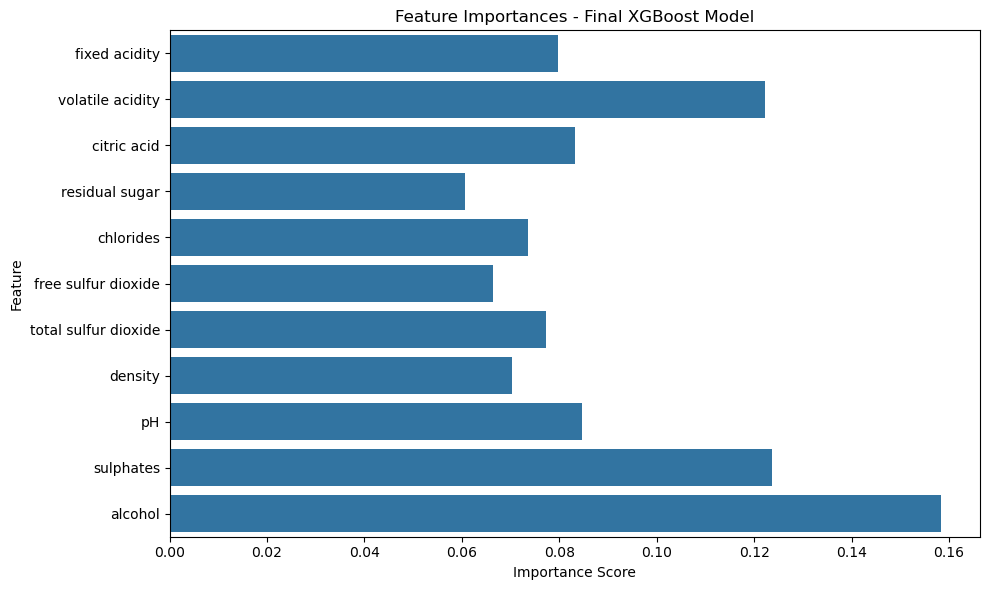

In [12]:
importances = final_model.feature_importances_
feat_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importances - Final XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Insights and Recommendations

- The final model achieved **over 94% accuracy** on the original imbalanced test set, indicating strong generalization performance.
- **Alcohol**, **sulphates**, and **volatile acidity** were the most influential features in determining wine quality.
- Our modeling approach allows wineries to estimate wine quality using objective lab measurements instead of relying solely on sensory testing.
